In [ ]:
# -*- coding: utf-8 -*-
"""
@author: Théo Lebeau, Pierre Guiot, Cateline Lantz, Lucie Degott, Laura Nardelli, Hervé Dole
"""

'\n@author: Théo Lebeau, Marion Zannese, Pierre Guiot, Cateline Lantz, Lucie Degott\n'

# Installation/Importation des bibliothèques et dépendances



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install -q ipympl
from google.colab import output
output.enable_custom_widget_manager()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import glob
from astropy.io import fits # Pour ouvrir et manipuler les données
from scipy.ndimage import rotate # Pour la rotation des images
from scipy.optimize import curve_fit # Pour la régression linéaire


# Définition de quelques fonctions utiles de manipulation des images (le détail de leur fonctionnement ne fait pas partie du DM, cette cellule est à part)

In [ ]:
#Fonctions importées de la librairie CASTOR (créée pour la coupole d'Orsay par Gabriel Pelouze)

from copy import deepcopy
from tqdm import tqdm
from scipy.signal import fftconvolve

def align_images(Img, img_ref=0, xaxis=True, yaxis=True,
                 gauss=True, sigma=0.5):
    '''Align a series of image relatively to the img_ref,
    along the x and y-axis.
    Parmeters
    =========
    Img : 3D ndarray
        The array of 2D spectra (images) to align.
    img_ref : int (default: 0)
        The index of the image taken as a reference.
    xaxis : bool (default: True)
        Enable x-axis alignment.
    yaxis : bool (default: True)
        Enable y-axis alignment.
    gauss : bool (default: True)
        If True, the images are convolve with a 2D gaussian
        to reduce the effects of sharpy edges.
    sigma : float (default : 0.5)
        If gauss=True, the standard deviation of the use gaussian.
    Returns
    =======
    Img_align : 3D ndarray
        The aligned array of 2D spectra.
    '''
    N, Ysize, Xsize = Img.shape
    Img2 = deepcopy(Img)
    # Gaussian convolution
    if gauss:
        X, Y = np.linspace(-1, 1, Xsize), np.linspace(-1, 1, Ysize)
        G = gauss2d(X, Y, 1, 0, 0, sigma, sigma)
        for i in range(N):
            Img2 *= G
    # Shift determination using FFT convolution
    ref = Img2[img_ref]
    x_dith, y_dith = np.zeros(N, dtype=int), np.zeros(N, dtype=int)
    for i in tqdm(range(N)):
        x_dith[i], y_dith[i] = cross_correlation(ref, Img2[i])
    if not xaxis:
        x_dith[:] = 0
    if not yaxis:
        y_dith[:] = 0
    # Creation of a new set of images, with new dimensions
    x0 = np.max(np.abs(x_dith))
    y0 = np.max(np.abs(y_dith))
    Xnew = Xsize + 2*x0
    Ynew = Ysize + 2*y0
    Img_align = np.zeros((N, Ynew, Xnew))
    # Alignement
    for i in range(N):
        Img_align[i, y0+y_dith[i]:y0+Ysize+y_dith[i], x0+x_dith[i]:x0+Xsize+x_dith[i]] = Img[i]
    # Output
    return Img_align



def gauss2d(x, y, a, x0, y0, sigmax, sigmay):
    '''Compute a 2D gaussian on a grid generated from the
    input x and y arrays.
    G = a * exp( -(x-x0)**2/(2*sigmax**2) - (y-y0)**2/(2*sigmay**2) )
    Parameters
    ==========
    x : 1D ndarray
        The x-axis values.
    y : 1D ndarray
        The y-axis values.
    a : float
        The amplitude of the gaussian.
    x0 : float
        The x-coordinate of the gaussian center.
    y0 : float
        The y-coordinate of the gaussian center.
    sigmax : float
        The standard deviation along the x-axis.
    sigmay : float
        The standard deviation along the y-axis.
    Returns
    =======
    G : 2D ndarray
        The 2D gaussian computed of the (x, y) grid.
    '''
    X, Y = np.meshgrid(x, y)
    G = a * np.exp( -(X-x0)**2/(2*sigmax**2) - (Y-y0)**2/(2*sigmay**2) )
    return G

def cross_correlation(img1, img2):
    '''Determine the shift along the x and y axis between the two input
    2D images, using a 2D FFT convolution.
    Parameters
    ==========
    img1 : 2D ndarray
        The reference 2D spectrum.
    img2 : 2D ndarray
        The 2D spectrum to align
    Returns
    =======
    x_dith : int
        The shift along the x-axis in pixels.
    y_dith : int
        The shift along the y-axis in pixels.
    '''
    ysize, xsize = img1.shape
    corr = fftconvolve(img1, img2[::-1, ::-1], mode='same')
    y_dith, x_dith = np.where(corr == np.max(corr))
    x_dith = int(x_dith) - xsize//2
    y_dith = int(y_dith) - ysize//2
    return x_dith, y_dith

# Lecture des données

Les prochaines lignes permettent d'accéder aux images de science, de Dark, de calib et potentiellement de Flats, pour les lire et récupérer les données sous forme d'array numpy.

Les chemins doivent prendre la forme `chemin/vers/les/fichiers/*`, l'astérique servant à signifier que vous récupérez tous les fichiers à l'intérieur du dossier qui vous intéresse.

**Vous pouvez copier le chemin vers vos données depuis le menu déroulant sur la gauche en cliquant sur les 3 points veritcaux à la droite de votre dossier. Les fichiers que vous avez copiés sur votre Google Drive sont dans le répertoire /content/drive/MyDrive/Colab Notebooks**

Dans la cellule ci-dessous, vous pourrez trouver trois boucles `for` (une pour chaque type de donnée, quatre si vous utilisez le flat), ainsi que des tableaux `XXX_cube`:

* Les boucles `for` parcourent tous les fichiers présents dans le chemin fourni, en les triant dans l'ordre alphanumérique, et en fournissant une variable "compteur" et une variable "nom de fichier" à la boucle `for`.
* Les tableaux `XXX_cube` contiennent 3 dimensions selon lesquelles sont stockées les données : (n,l,c) où n est le numéro de l'image dans la série d'acquisitions, l la dimension des lignes de l'image et c la dimension des colonnes de l'image.

In [ ]:
science_path = "" # Chemin vers les données de science
dark_path = "" # Chemin vers les dark
flat_path = "" # Chemin vers les flat (si nécessaire)
calib_path = "" # Chemin vers les calibs

science_cube = []
dark_cube = []
flat_cube = []
calib_cube = []

for i, file in enumerate(sorted(glob.glob(science_path))):
    hdu = fits.open(file)
    image = hdu[0].data
    science_cube.append(image)

science_cube = np.asarray(science_cube, dtype=np.float64)

for i, file in enumerate(sorted(glob.glob(dark_path))):
    hdu = fits.open(file)
    image = hdu[0].data
    dark_cube.append(image)

dark_cube = np.asarray(dark_cube, dtype=np.float64)

for i, file in enumerate(sorted(glob.glob(flat_path))):
    hdu = fits.open(file)
    image = hdu[0].data
    flat_cube.append(image)

flat_cube = np.asarray(flat_cube, dtype=np.float64)

for i, file in enumerate(sorted(glob.glob(calib_path))):
    hdu = fits.open(file)
    image = hdu[0].data
    calib_cube.append(image)

calib_cube = np.asarray(calib_cube, dtype=np.float64)

### Visualisation

Afin d'améliorer la visualisation des contrastes des images, vous pourrez spécifier des mots-clef `vmin` et `vmax` à l'intérieur des `plt.imshow()`.
Sans spécifier ces seuils vous risquez de vous retrouver avec des images entièrement blanches, noires, ou saturées.

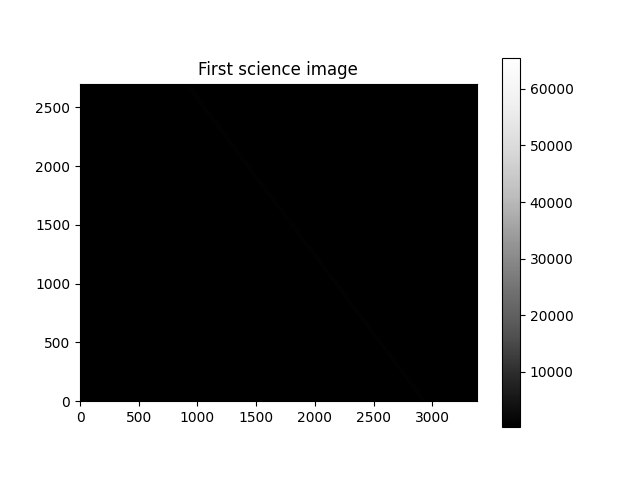

In [ ]:
%matplotlib ipympl

plt.figure(1)
plt.clf()
plt.imshow(science_cube[0], interpolation=None, origin='lower', cmap='Greys_r') #vmin = , vmax =
plt.title('First science image')
plt.colorbar()
plt.show()

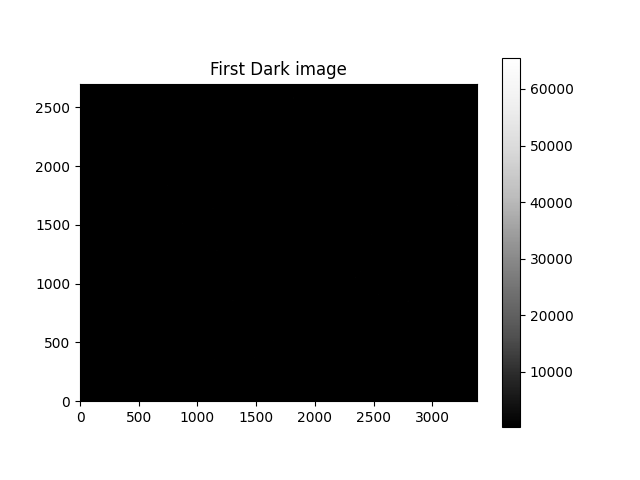

In [ ]:
%matplotlib ipympl

plt.figure(2)
plt.clf()
plt.imshow(dark_cube[0], interpolation=None, origin='lower', cmap='Greys_r')
plt.title('First Dark image')
plt.colorbar()
plt.show()

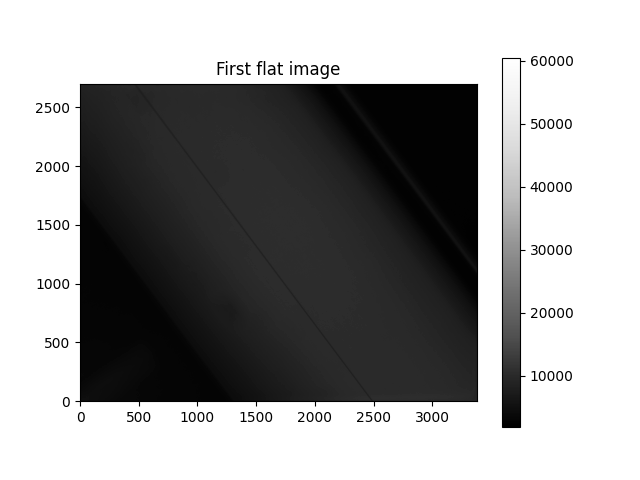

In [ ]:
%matplotlib ipympl

plt.figure(3)
plt.clf()
plt.imshow(flat_cube[0], interpolation=None, origin='lower', cmap='Greys_r')
plt.title('First flat image')
plt.colorbar()
plt.show()

# Réduction des données

Dans cette section, le but est de réduire les données brutes de science, pour parvenir à des données exploitables scientifiquement.

Une image dite réduite, $I_{corr}$ ici, est l'image brute, $I_{brute}$, à laquelle on soustrait d'abord la moyenne (temporelle) des images de dark, $<I_{Dark}>$, qu'on nomme aussi master dark.

Quand les images de flat sont de qualtié suffisante, c'est qui est le cas pour ce DM, on divise la résultat de la soustraction par la moyenne (temporelle) des images de flat, $<I_{flat}>$.

On l'appelle master flat: $MF=<I_{flat}>$


Et on normalise en divisant par la moyenne sur les pixels (donc spatiale cette fois) du master flat : $\overline{MF}$.

La formule complète, que vous pouver retrouver en annexe A.3 du poly de TP,   est donc la suivante :

 $I_{corr}=\frac{I_{brute}-<I_{Dark}>}{MF/\overline{MF}}$

 Les cellules ci-dessous sont la traduction de ces équations

In [ ]:
master_dark = np.mean(dark_cube, axis=0) #Le master dark, c'est une image

reduced_science_cube = np.zeros(np.shape(science_cube))
for i in range(science_cube.shape[0]):
    reduced_science_cube[i,:,:] = science_cube[i,:,:] - master_dark #On soustrait le master dark aux images brutes

master_flat = np.mean(flat_cube , axis=0) #Le master flat, c'est une image

spatial_mean=np.mean(master_flat) #La moyenne spatiale du master flat, c'est l'intensité moyenne sur les pixels c'est donc un nombre.

normalized_master_flat = master_flat/spatial_mean #On divise le master flat par sa valeur moyenne pour normaliser l'intensité, c'est une image


for i in range(science_cube.shape[0]):
    reduced_science_cube[i,:,:] = reduced_science_cube[i,:,:]/normalized_master_flat #C'est la deuxième partie de l'équation de l'énoncé, on l'utilise quand nos données de flat sont de qualité.
    #reduced_science_cube est une liste d'image


### Visualisation

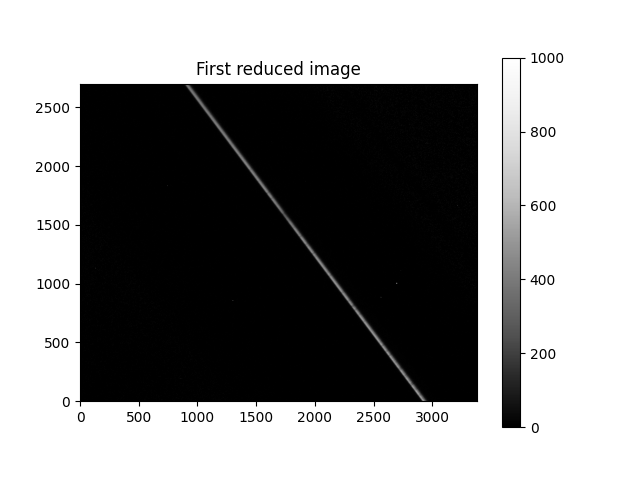

In [ ]:
%matplotlib ipympl

plt.figure(4)
plt.clf()
plt.imshow(reduced_science_cube[0,:,:], interpolation=None, origin='lower', cmap='Greys_r')#, vmin =  , vmax =
# Essayer de modifier le premier indice du cube pour tester.
plt.title('First reduced image')
plt.colorbar()
plt.show()

# Rotation des spectres

Le plus souvent, les spectres que vous obtiendrez en sortie de la réduction seront inclinés. Etant donné que votre but sera d'analyser des spectres, cela sera plus simple s'il suffit de récupérer une ligne dans un tableau numpy pour faire ce travail. Il faudra donc faire tourner l'image selon un angle que vous aurez déterminé pour que le spectre soit horizontal.

Pour pouvoir étalonner facilement les spectres, il faut faire cette démarche avec l'image de calibration également.

L'angle optimal de rotation peut être déterminé à l'aide de DS9. Attention l'angle optimal pour la rotation par python est l'opposé de l'angle donné par DS9 $\theta_{opt, python} = - \theta_{opt, DS9}$

In [ ]:
### Données de science ###

rotated_cube = []
rotation_angle = # Angle en degrés à déterminer à l'aide de DS9 pour mettre le spectre horizontal.
for i in range(reduced_science_cube.shape[0]):
    rotated_cube.append(rotate(reduced_science_cube[i,:,:], rotation_angle))
rotated_cube = np.asarray(rotated_cube)

### Visualisation

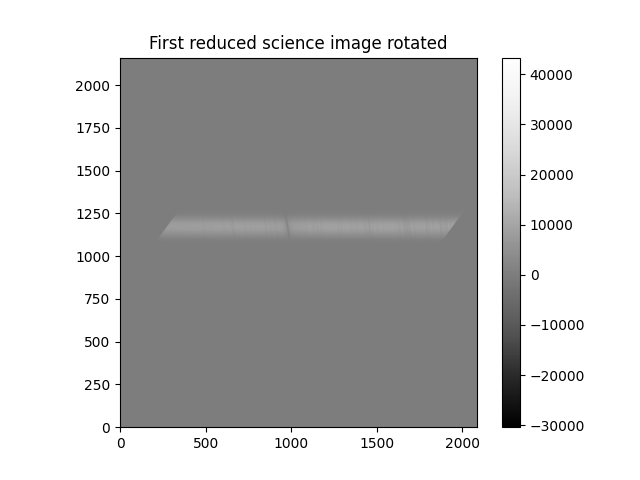

In [ ]:
%matplotlib ipympl

### Données de science ###

plt.figure(5)
plt.clf()
plt.imshow(rotated_cube[0,:,:], interpolation=None, origin='lower', cmap='Greys_r') #, vmin =  ,  vmax = )
plt.title('First reduced science image rotated')
plt.colorbar()
plt.show()

# Augmentation du rapport signal sur bruit: alignement des images avant stacking

Lors de l'acquisition de données, notre but est de recueillir le plus de signal possible de l'objet à étudier. On mesure la qualité de l'acquisition avec le rapport signal sur bruit ( SNR : Signal to Noise Ratio, voir section 3.1 du poly de TP), c'est-à-dire le ratio de tous les électrons captés sur les électrons associés au bruit.

Par définition, si on a N électrons, on aura $\sqrt N$ électrons (voir l'annexe 1.3 du poly) de bruit donc on a $SNR=\frac{N}{\sqrt N} ∝ \sqrt N$. Le nombre d'électrons détectés étant proportionnel au temps d'exposition, plus le temps d'exposition sera long, plus le signal scientifique ressortira du bruit. Mais le temps d'acquisition unitaire étant limité (cf. poly de TP), il est également utile d'acquérir plusieurs images au même temps de pose puis de les sommer pour faire augmenter le SNR. Le problème est que la source va légèrement se déplacer sur l'image au cours du temps, il est donc nécessaire d'aligner les images entre elles avant de les sommer, ce que fait la ligne de code ci-dessous.


In [ ]:
aligned_rotated_cube=align_images(rotated_cube)

100%|██████████| 6/6 [00:10<00:00,  1.75s/it]


# Définition de la zone du spectre

On va ensuite chercher la zone contenant le signal significatif du spectre  dans les spectres alignés. Pour cela on effectue une coupe verticale (dimension spatiale de l'image, perpendiculaire au spectre) dans l'image, on repère la zone d'intérêt et les zones qui ne sont que du bruit. Un critère quantitatif permettant de déterminer ces limites pourrait être l'écart-type.

Afin d'augmenter encore le SNR on va également moyenner le signal dans chaque image sur quelques lignes dans la zone d'intérêt.

 **Attention** pour les sujets portant sur des objets spatialement résolus (ex: Lune, Géantes), la dimension spatiale du spectre contient aussi une information, il ne faut donc pas moyenner les lignes. Ce n'est pas le cas pour le DM (les étoiles sont des objets non-résolus avec notre matériel, ormis le Soleil évidemment)

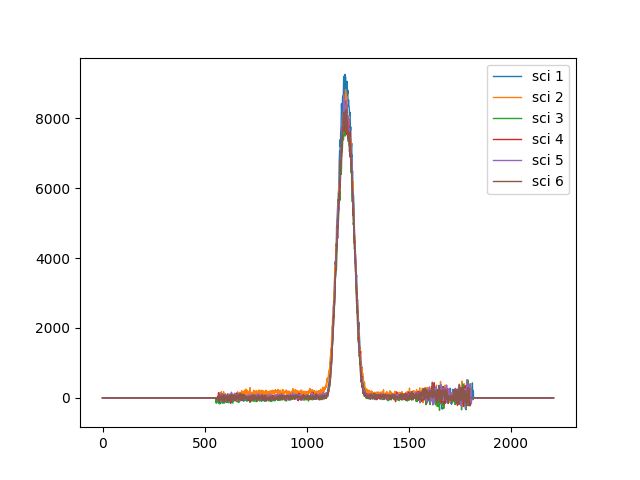

Text(0.5, 1.0, 'Vertical cut')

In [ ]:
plt.figure(6)
plt.clf()
for i in range(len(aligned_rotated_cube[:,0,0])):
   plt.plot(aligned_rotated_cube[i,:,1],label='sci '+str(i+1),lw=1) # 1 à modifier
plt.legend()
plt.show()
plt.ylabel('Arbitrary intensity')
plt.xlabel('Line arrays index')
plt.title('Vertical cut')

# Extraction du spectre 1D et moyenne sur les lignes


Afin d'augmenter encore le SNR on va également moyenner le signal dans chaque image sur quelques lignes dans la zone d'intérêt.

 **Attention** pour les sujets portant sur des objets résolus (ex: Lune, Géantes), la dimension spatiale du spectre contient aussi une information, il ne faut donc pas moyenner les lignes. Ce n'est pas le cas pour le DM (les étoiles sont des objets non-résolus avec notre matériel, ormis le Soleil évidemment)

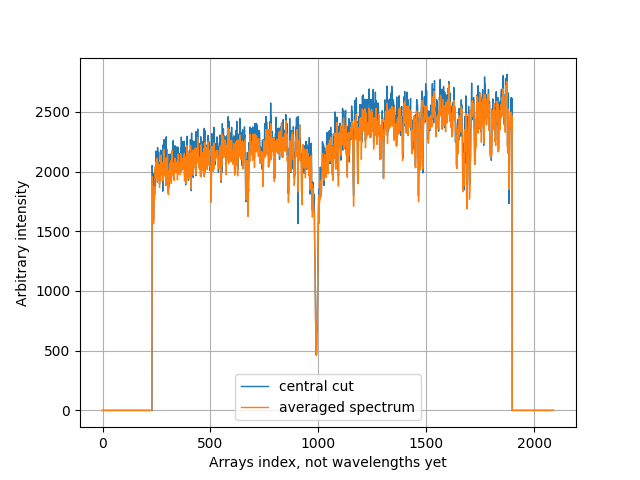

In [ ]:
%matplotlib ipympl

average_pixel= # Pixel central autour duquel les 20 pixels voisins sont moyennés pour "lisser" le spectre extrait.

avg_spectrum=[]


#======================================================================================================
# À ne faire que si la dimension spatiale de vos données n'a pas d'importance ! Sinon, ne pas moyenner.
for i in range(len(aligned_rotated_cube[:,0,0])):
  extract_avg_spectrum= np.mean(aligned_rotated_cube[i,average_pixel-1:average_pixel+1,:], axis=0) # A modifier pour choisir le nombre de lignes sur lesquelles nous moyennons
  avg_spectrum.append(extract_avg_spectrum)
avg_spectrum=np.array(avg_spectrum)
#======================================================================================================
#======================================================================================================
# Si on ne veut pas moyenner
spectrum=aligned_rotated_cube[:,average_pixel,:]
#======================================================================================================

plt.figure(7)
plt.clf()
plt.plot(spectrum[0,:], lw=1, label='central cut')
plt.plot(avg_spectrum[0,:], lw=1, label='averaged spectrum')
plt.ylabel('Arbitrary intensity')
plt.xlabel('Arrays index, not wavelengths yet')
plt.title(' ') # À modifier
plt.grid()
plt.ylim()
plt.legend(loc='best')
plt.show()

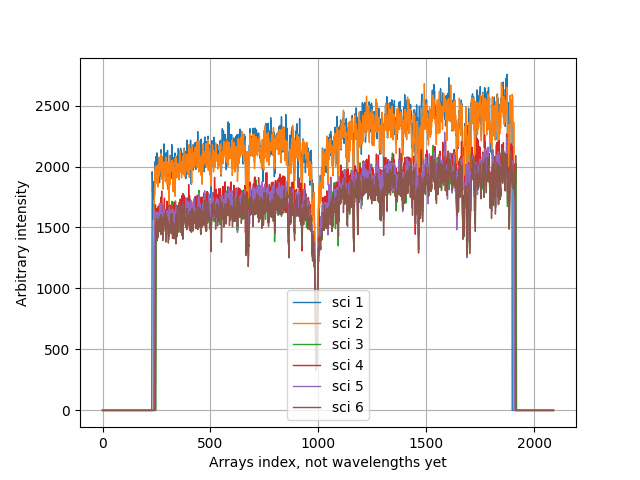

In [ ]:
plt.figure(8)
plt.clf()
for i in range(len(avg_spectrum)):
  plt.plot(avg_spectrum[i,:], lw=1, label='sci '+str(i+1)) #ligne à utiliser si on moyenne
  #plt.plot(spectrum[i,:], lw=1, label='sci '+str(i+1)) #ligne à utiliser si on ne moyenne pas
plt.ylabel('Arbitrary intensity')
plt.xlabel('Arrays index, not wavelengths yet')
plt.title(' ') # À modifier
plt.grid()
plt.ylim()
plt.legend(loc='best')
plt.show()

# Moyenne

On va moyenner les spectres alignés pour augmenter le SNR. Certaines acquisitions sont de mauvaises qualité, il ne faut pas les prendre pour la moyenne (ou sommation). En utilisant la figure 8 ci-dessus, sélectionnez les spectres de bonne qualité en notant leur numéro de fichier (le X à la fin de du fichier 'data_00X.fit' en supposant que les données de science sont classées de 1 à N) dans la liste index.

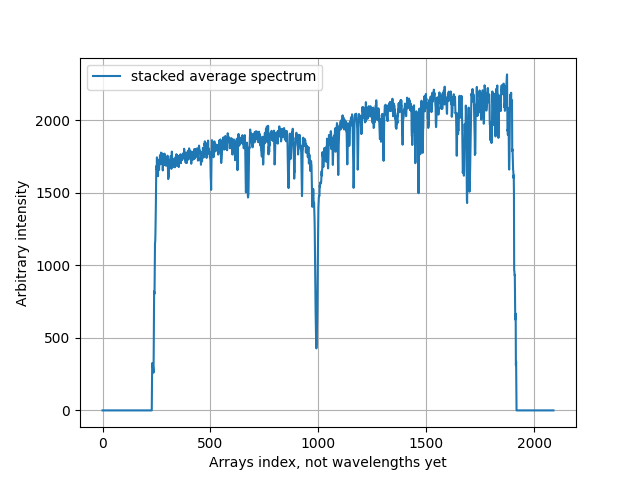

In [ ]:
index=np.array([]) # A remplir avec l'indice des spectres à garder pour l'analyse
index=index-1

stacked_average_spectrum=np.mean(avg_spectrum[index,:], axis=0)#ligne à utiliser si on moyenne
#stacked_spectrum=np.mean(spectrum[index,:], axis=0)#ligne à utiliser si on ne moyenne pas

plt.figure(9)
plt.clf()
plt.plot(stacked_average_spectrum,label='stacked average spectrum')
#plt.plot(stacked_spectrum,label='stacked spectrum')
plt.ylabel('Arbitrary intensity')
plt.xlabel('Arrays index, not wavelengths yet')
plt.title(' ') # À modifier
plt.grid()
plt.ylim()
plt.legend(loc='best')
plt.show()

#Calibration

Pour faire l'analyse des résulats il nous faut convertir l'axe des abcisses du spectre de pixel à longueurs d'onde. Pour faire la conversion nous utilisons les données d'un spectre de référence (ici la lampe Argon-Néon dans le spectro). Il faut pour cela identifier la position en pixel de pics caractéristiques dans le spectre Ar-Ne grâce au spectre de référence (en longueur d'onde) en section 3.5.2 du poly de TP. Selon le réseau utilisé pendant la prise de données il faut utiliser le spectre à haute ou basse résolution. Il faut rentrer les valeurs dans les listes ci-dessous afin d'établir la relation affine pixel-$\lambda$.

In [ ]:
#Rotation du cube de calib
rotated_calib_cube = []
for i in range(calib_cube.shape[0]):
    rotated_calib_cube.append(rotate(calib_cube[i,:,:], rotation_angle))
rotated_calib_cube = np.asarray(rotated_calib_cube)

#Affichage de l'image de calib

plt.figure(10)
plt.clf()
plt.imshow(rotated_calib_cube[0,:,:], interpolation=None, origin='lower', cmap='Greys_r') #vmin = ,  vmax =
plt.title('First calib image rotated')
plt.colorbar()
plt.show()

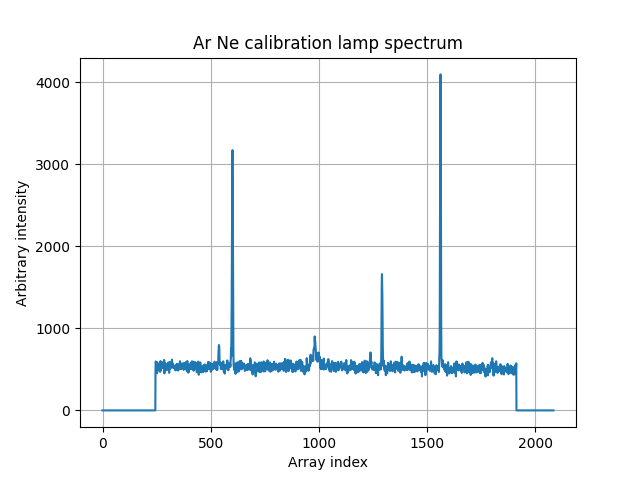

In [ ]:
plt.figure(11)
plt.clf()
plt.plot(rotated_calib_cube[0,average_pixel,:])
plt.xlabel('Array index')
plt.ylabel('Arbitrary intensity')
plt.title('Ar Ne calibration lamp spectrum')
plt.grid()
plt.show()

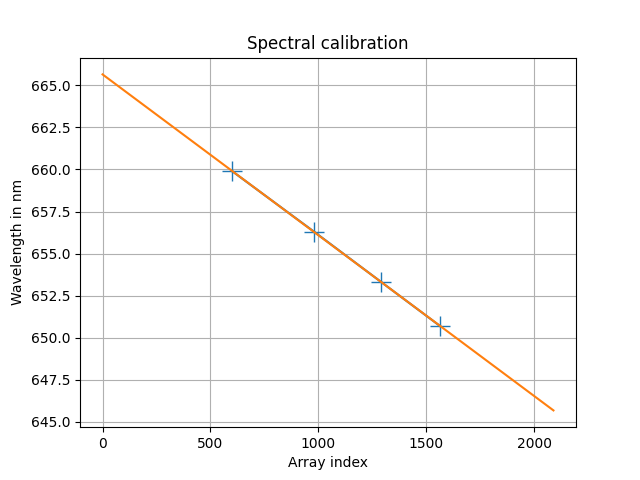

In [ ]:
pixels_peaks = np.array([]) # A remplir
peaks_lambda = np.array([]) # A remplir
def affine(x, a=1, b=1):
    return a*x + b

calib_wvl = curve_fit(affine, pixels_peaks, peaks_lambda, p0=[2, 50])

calib_wavelengths = affine(range(len(extract_avg_spectrum)), a=calib_wvl[0][0], b=calib_wvl[0][1])

plt.figure(12)
plt.clf()
plt.plot(pixels_peaks,peaks_lambda,marker='+',markersize=15)
plt.plot(calib_wavelengths)
plt.ylabel('Wavelength in nm')
plt.xlabel('Array index')
plt.title('Spectral calibration')
plt.grid()
plt.show()

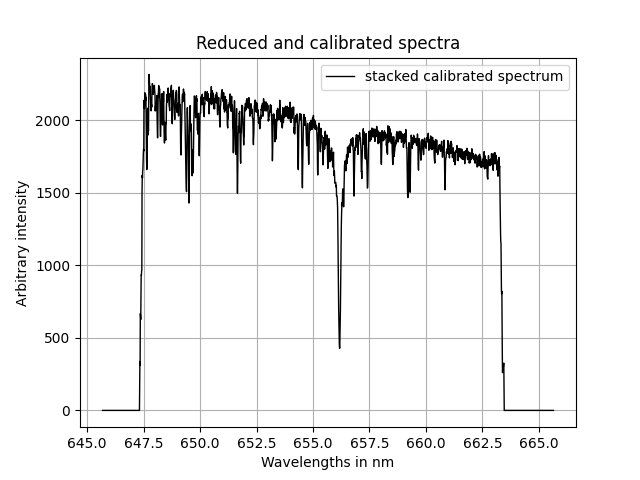

Traitement terminé, place à l'analyse !


In [ ]:

plt.figure(13)
plt.clf()
plt.plot(calib_wavelengths, stacked_average_spectrum, 'k-', lw=1, label='stacked calibrated spectrum')
#plt.plot(calib_wavelengths, stacked_spectrum, 'k-', lw=1, label='stacked calibrated spectrum')
plt.ylabel('Arbitrary intensity')
plt.xlabel('Wavelengths in nm')
plt.title('Reduced and calibrated spectra')
plt.grid()
plt.legend(loc='best')
#plt.ylim(0, 2000) # A modifier
#plt.xlim(530,885) # A modifier
#plt.yscale('log') # Pour la visualisation en échelle log si nécessaire
plt.show()


print("Traitement terminé, place à l'analyse !")